In [1]:
import pandas as pd
df = pd.read_csv('西屯日報表train.csv',engine = 'python')
df.columns

Index(['month', 'day', 'hour', 'RH', 'StnPres', 'Temperature', 'AMB_TEMP',
       'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PH_RAIN', 'RAINFALL',
       'RAIN_COND', 'PM10', 'RH.1', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR', 'PM2.5'],
      dtype='object')

In [2]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Using TensorFlow backend.


In [4]:
from matplotlib import pyplot
%matplotlib qt5
values = df.values
# specify columns to plot
groups = [25]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [3]:
from sklearn import preprocessing 
import pandas as pd
import numpy as np
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s_tsub%d' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s_t' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s_tadd%d' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

In [4]:
c = ['PM2.5']
dataset = df[c]
values = dataset.values
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled = scaler.fit_transform(values[:,[0]])
scaled

array([[0.17112299],
       [0.21925134],
       [0.22994652],
       ...,
       [0.07486631],
       [0.04812834],
       [0.02673797]])

In [5]:
columns = ['PM2.5']
# frame as supervised learning
reframed = series_to_supervised(scaled,columns, 12, 1)
def select(attr):
    c = []
    for i in range(4,13):
        c.append(attr + '_tsub' + str(i))
    return c

In [6]:
c = []
c.extend(select('PM2.5'))
reframed_df = reframed[c]

In [7]:
pm = reframed_df.values.reshape(reframed_df.values.shape[0],reframed_df.values.shape[1],1)
pm.shape

(52572, 9, 1)

In [8]:
from sklearn.metrics import mean_squared_error
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam

Using TensorFlow backend.


In [9]:
### DEFINE LSTM AUTOENCODER ###
inputs_ae = Input(shape=(9,1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 128)            66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 32)             20608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 1)              33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [121]:
### TRAIN AUTOENCODER ###
sequence_autoencoder.fit(pm, 
                         pm, batch_size=40, epochs=50, verbose=2, shuffle=True)

Epoch 1/50
 - 43s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/50
 - 41s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/50
 - 41s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/50
 - 41s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 5/50
 - 41s - loss: 9.4976e-04 - mean_squared_error: 9.4976e-04
Epoch 6/50
 - 40s - loss: 8.9514e-04 - mean_squared_error: 8.9514e-04
Epoch 7/50
 - 40s - loss: 8.7353e-04 - mean_squared_error: 8.7353e-04
Epoch 8/50
 - 40s - loss: 8.0376e-04 - mean_squared_error: 8.0376e-04
Epoch 9/50
 - 41s - loss: 6.9362e-04 - mean_squared_error: 6.9362e-04
Epoch 10/50
 - 40s - loss: 5.9825e-04 - mean_squared_error: 5.9825e-04
Epoch 11/50
 - 40s - loss: 5.8748e-04 - mean_squared_error: 5.8748e-04
Epoch 12/50
 - 40s - loss: 5.4129e-04 - mean_squared_error: 5.4129e-04
Epoch 13/50
 - 40s - loss: 4.7147e-04 - mean_squared_error: 4.7147e-04
Epoch 14/50
 - 40s - loss: 4.4393e-04 - mean_squared_error: 4.4393e-04
Epoch 15/50
 - 40s - loss: 4.5820e-04 - mean_sq

In [10]:
from keras.models import load_model
sequence_autoencoder.save('autolstm.h5') 
# 從 HDF5 檔案中載入模型
sequence_autoencoder = load_model('autolstm.h5')

KeyboardInterrupt: 

In [10]:
cf = [ 'RH', 'StnPres', 'Temperature', 'AMB_TEMP','CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx',
      'O3', 'PH_RAIN', 'RAINFALL','RAIN_COND', 'PM10', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC','WIND_SPEED',
      'WS_HR', 'PM2.5']
datasetf = df[cf]
valuesf = datasetf.values
# normalize features
scaler_f = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaledf = scaler_f.fit_transform(valuesf[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]])
scaledf

array([[0.74117647, 0.82657343, 0.20858896, ..., 0.14166667, 0.04807692,
        0.06153846],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.02472222, 0.01442308,
        0.03076923],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.96111111, 0.03846154,
        0.03076923],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.03888889, 0.125     ,
        0.22307692],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.03888889, 0.10576923,
        0.18461538],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.04444444, 0.09615385,
        0.16923077]])

In [11]:
#scaled = np.array(values[:,0],scaled.data)
label_scalerf = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled_conf = np.c_[scaledf,label_scalerf.fit_transform(valuesf[:,21].reshape(-1, 1))]
scaled_conf

array([[0.74117647, 0.82657343, 0.20858896, ..., 0.04807692, 0.06153846,
        0.17112299],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.01442308, 0.03076923,
        0.21925134],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.03846154, 0.03076923,
        0.22994652],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.125     , 0.22307692,
        0.07486631],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.10576923, 0.18461538,
        0.04812834],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.09615385, 0.16923077,
        0.02673797]])

In [12]:
#columns = [ 'RH', 'StnPres', 'Temperature', 'CO', 'NO',
#       'O3', 'PH_RAIN', 'RAINFALL', 'SO2', 'WIND_DIREC', 'WIND_SPEED',
#       'PM2.5']
# frame as supervised learning
reframedf = series_to_supervised(scaled_conf,cf, 12, 1)

In [13]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###
encoder = Model(inputs_ae, encoded_ae)
XXr = encoder.predict(pm)
XXr.shape

(52572, 9, 128)

In [14]:
for i in range(len(cf) - 1):
    c = []
    c.extend(select(cf[i]))
    reframed_dff = reframedf[c]
    reframed_dff = reframed_dff.values.reshape((reframed_dff.shape[0],reframed_dff.shape[1],1))
    XXr = np.concatenate([XXr, reframed_dff] , axis=2)
XXr.shape

(52572, 9, 149)

In [15]:
yy = reframedf[['PM2.5_t']].values
yy.shape

(52572, 1)

In [16]:
XX = XXr[:]
y = yy[:]

In [17]:
from sklearn.model_selection import train_test_split  
train_X, test_X, train_y, test_y = train_test_split(XX, y, test_size=0.20, random_state=12) 
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42057, 9, 149) (42057, 1) (10515, 9, 149) (10515, 1)


In [18]:
test_y

array([[0.17647059],
       [0.16042781],
       [0.31550802],
       ...,
       [0.06951872],
       [0.23529412],
       [0.13368984]])

In [24]:
# cnnlstm
def baseline_model():
    # design network
    model = Sequential()
    #CNN
    model.add(Conv1D(filters=128, kernel_size=1, input_shape=(train_X.shape[1], train_X.shape[2],)))#kernel1 shape
    model.add(Dropout(0.2))
    model.add(Activation('selu'))
    model.add(Conv1D(filters=128, kernel_size=1))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    #lstm
    model.add(LSTM(units=128, dropout=0.2,activation = 'sigmoid'))
    #model.add(LSTM(units=32, dropout=0.2,activation = 'sigmoid'))
    model.add(Dense(units = 100,activation = 'sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation = 'sigmoid'))#10
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [24]:
def baseline_model():
    model = Sequential()
    input_shape = (train_X.shape[1], train_X.shape[2])
    model.add(Bidirectional(LSTM(units=50),input_shape=input_shape))#,return_sequences=True
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    #model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [19]:
def baseline_model():
    inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm = LSTM(128, return_sequences=False, dropout=0.3)(inputs, training=True)
#    lstm = LSTM(32, return_sequences=False, dropout=0.3)(lstm, training=True)
    dense = Dense(100,activation = "sigmoid")(lstm)
    out = Dense(1,activation = "sigmoid")(dense)
    model = Model(inputs, out)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [20]:
model = baseline_model()

In [21]:
history = model.fit(train_X, train_y, epochs=40, batch_size=128,validation_data=(test_X, test_y), verbose=2, shuffle=True)

Train on 42057 samples, validate on 10515 samples
Epoch 1/40
 - 11s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 2/40
 - 9s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 3/40
 - 9s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/40
 - 9s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/40
 - 9s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/40
 - 9s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/40
 - 9s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 8/40
 - 9s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 9/40
 - 9s - loss: 0.0035 - mean_square

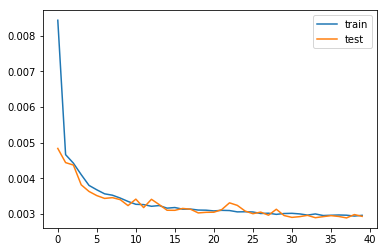

In [22]:
from matplotlib import pyplot
%matplotlib inline
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[0.3349132 ],
       [0.0943546 ],
       [0.35009816],
       ...,
       [0.07476425],
       [0.15373965],
       [0.08015868]], dtype=float32)

In [24]:
from keras import backend as K
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop1(r):
    enc = K.function([encoder.layers[0].input, K.learning_phase()], [encoder.layers[-1].output])
    NN = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    NN_pred = NN([test_X,r])
    return np.vstack(NN_pred)

In [25]:
### COMPUTE STOCHASTIC DROPOUT ###
from sklearn.metrics import mean_absolute_error
scores1 = []
for i in range(0,100):
    scores1.append(mean_absolute_error(stoc_drop1(0.5), test_y))
print(np.mean(scores1), np.std(scores1))

0.03906074406794482 0.00012386724245605073


In [26]:
def to_class(pre_pm):
    if pre_pm <= 11:
        return 0
    elif 11 < pre_pm <= 23:
        return  1
    elif 23 < pre_pm <= 35:
        return  2
    elif 35 < pre_pm <= 41:
        return  3
    elif 41 < pre_pm <= 47:
        return  4
    elif 47 < pre_pm <= 53:
        return  5
    elif 53 < pre_pm <= 58:
        return  6
    elif 58 < pre_pm <= 64:
        return  7
    elif 64 < pre_pm <= 70:
        return  8
    elif 70 < pre_pm:
        return  9
count = 0
ally = 0
for i in range(len(yhat)):
    after_pm = label_scalerf.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scalerf.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(after_pm) >= 6:
        ally = ally + 1
        if to_class(after_pm) == to_class(pre_pm) :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
            count = count + 1
print(count/ally)#len(yhat))

0.2297979797979798


In [27]:
count = 0
ally = 0
for i in range(len(yhat)):
    after_pm = label_scalerf.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scalerf.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(pre_pm) >= 6:
        ally = ally + 1
        if to_class(after_pm) >= 6 :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
            count = count + 1
print(count/ally)

0.3916184971098266


In [28]:
inv_yhat = label_scalerf.inverse_transform(yhat)
inv_y = label_scalerf.inverse_transform(test_y.reshape(-1, 1))
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
# calculate average error percentage
avg = np.average(inv_y)
error_percentage = rmse / avg
print(error_percentage)

10.188205113819865
0.41370815054477067


In [30]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(inv_y, label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(inv_yhat, label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()

In [31]:
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error,r2_score,mean_squared_error
print("The Explained Variance: %.2f" % explained_variance_score(inv_y, inv_yhat))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(inv_y,inv_yhat))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(inv_y, inv_yhat))
print("The r2_score: %.2f" % r2_score(inv_y, inv_yhat)) 
print("The mse: %.2f" % mean_squared_error(inv_y, inv_yhat))

The Explained Variance: 0.65
The Mean Absolute Error: 7.32 degrees Celcius
The Median Absolute Error: 5.46 degrees Celcius
The r2_score: 0.65
The mse: 103.80
